# Star Space in Tensorflow/Keras

https://medium.com/@pavan.11.1987/embedding-all-things-with-starspace-and-keras-1df46e4db8f0

In [27]:
%%capture requirements

!pip install tensorflow

In [28]:
import tensorflow as tf

In [29]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [30]:
def triple_loss(y_true, y_pred):
    """
        Keras Loss Function always expect y_true & y_pred
        
        see 
        https://keras.io/api/losses/#creating-custom-losses
        
    """
    MARGIN = .85
    
    pos_input_emb = y_pred[:, 0, :]
    pos_target_emb = y_pred[:, 1, :]
    neg_target_embs = y_pred[:, 2:, :]

    scores_pos = tf.expand_dims(tf.reduce_sum(tf.multiply(pos_input_emb, pos_target_emb), -1), axis = -1)
    scores_neg = tf.expand_dims(tf.reduce_sum(tf.multiply(pos_input_emb, tf.math.reduce_mean(neg_target_embs, axis = 1)), -1), axis = -1)

    loss_matrix = tf.maximum(0., MARGIN - scores_pos + scores_neg)
    loss = tf.reduce_sum(loss_matrix)

    return loss

In [31]:
import tensorflow as tf
import numpy as np
import random

from scipy.spatial.distance import cosine as dist
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt

In [32]:
positive_input = tf.keras.layers.Input(shape = (1, 784), name='positive_input')
positive_target_input = tf.keras.layers.Input(shape = (1, ), name='positive_target')

negative_target_inputs = tf.keras.layers.Input(shape = (10, ), name='negative_targets')

In [33]:
EMBEDDING_DIMENSION = 64

In [34]:
input_dense_layer = tf.keras.layers.Dense(EMBEDDING_DIMENSION, name='input_dense')

target_embedding_layer = tf.keras.layers.Embedding(input_dim = 10, output_dim = EMBEDDING_DIMENSION, name='target_embedding')
target_dense_layer = tf.keras.layers.Dense(EMBEDDING_DIMENSION, name='target_dense')

In [35]:
pos_input_embedding = tf.nn.l2_normalize(input_dense_layer(positive_input), -1, name='input_embedding')

pos_target_embedding = tf.nn.l2_normalize(target_dense_layer(target_embedding_layer(positive_target_input)), -1, name='positive_target_embedding')
neg_target_embedding = tf.nn.l2_normalize(target_dense_layer(target_embedding_layer(negative_target_inputs)), -1, name='negative_target_embedding')

In [36]:
packed_output_embeddings = tf.keras.layers.concatenate([pos_input_embedding, pos_target_embedding, neg_target_embedding], axis = 1, name='output_embedding')

In [37]:
model = tf.keras.models.Model(inputs = [positive_input, positive_target_input, negative_target_inputs], outputs = packed_output_embeddings)

adam_opt = tf.keras.optimizers.Adam()

model.compile(loss = triple_loss, optimizer = adam_opt, )

In [38]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_target (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
negative_targets (InputLayer)   [(None, 10)]         0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 1, 784)]     0                                            
__________________________________________________________________________________________________
target_embedding (Embedding)    multiple             640         positive_target[0][0]            
                                                                 negative_targets[0][0]     

In [39]:
input_encoder_model = tf.keras.models.Model(inputs = positive_input, outputs = pos_input_embedding)

target_encoder_model = tf.keras.models.Model(inputs = positive_target_input, outputs = pos_target_embedding)

In [40]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/255.
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/255.

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

data = (x_train, y_train, x_test, y_test)

In [56]:
def generate_batches_vectorize(x, y, NEG_SAMPLE_SIZE=10):
    input_x = np.expand_dims(x, axis=1)
    labels_x = y
    
    M = np.random.randint(low=1,high=10, size=(y.shape[0],NEG_SAMPLE_SIZE))
    neg_labels = (M + np.tile(y,(1,10))) % 10
    
    return input_x, labels_x, neg_labels


In [57]:
x_train, y_train, x_test, y_test = data

train_positive_input_batches, train_positive_batch_targets, train_negative_batch_targets = generate_batches_vectorize(x_train, y_train)
test_positive_input_batches, test_positive_batch_targets, test_negative_batch_targets = generate_batches_vectorize(x_test, y_test)

train_dummy_outputs = np.zeros((len(train_positive_input_batches), 12, 256))
test_dummy_outputs = np.zeros((len(test_positive_input_batches), 12, 256))

In [60]:
train_negative_batch_targets


array([[9, 2, 8, ..., 1, 3, 3],
       [2, 6, 7, ..., 9, 5, 7],
       [7, 0, 0, ..., 7, 3, 2],
       ...,
       [3, 3, 2, ..., 8, 9, 0],
       [1, 4, 0, ..., 1, 3, 0],
       [4, 6, 1, ..., 0, 1, 7]])

In [43]:
train_positive_input_batches = train_positive_input_batches.reshape(len(train_positive_input_batches), 1, 784)
train_positive_batch_targets = train_positive_batch_targets.reshape(len(train_positive_batch_targets), 1)
train_negative_batch_targets = train_negative_batch_targets.reshape(len(train_negative_batch_targets), 10)

test_positive_input_batches = test_positive_input_batches.reshape(len(test_positive_input_batches), 1, 784)
test_positive_batch_targets = test_positive_batch_targets.reshape(len(test_positive_batch_targets), 1)
test_negative_batch_targets = test_negative_batch_targets.reshape(len(test_negative_batch_targets), 10)

In [44]:
model.fit([train_positive_input_batches, train_positive_batch_targets, train_negative_batch_targets], train_dummy_outputs, epochs = 10,\
          batch_size = 256,\
         validation_data = ([test_positive_input_batches, test_positive_batch_targets, test_negative_batch_targets], test_dummy_outputs))

2021-10-06 09:47:47.774265: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/10
235/235 [==============================] - 11s 9ms/step - loss: 29.6085 - val_loss: 16.5385
Epoch 2/10
235/235 [==============================] - 2s 8ms/step - loss: 15.5173 - val_loss: 15.0480
Epoch 3/10
235/235 [==============================] - 2s 7ms/step - loss: 14.4183 - val_loss: 14.3482
Epoch 4/10
235/235 [==============================] - 2s 7ms/step - loss: 13.9506 - val_loss: 14.0761
Epoch 5/10
235/235 [==============================] - 2s 7ms/step - loss: 13.6351 - val_loss: 14.0846
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 13.3887 - val_loss: 13.8014
Epoch 7/10
235/235 [==============================] - 2s 7ms/step - loss: 13.2639 - val_loss: 13.7494
Epoch 8/10
235/235 [==============================] - 2s 7ms/step - loss: 13.1595 - val_loss: 13.8886
Epoch 9/10
235/235 [==============================] - 2s 7ms/step - loss: 13.0452 - val_loss: 13.6201
Epoch 10/10
235/235 [==============================] - 2s 7ms/step - loss: 13.033

In [20]:
target_encodings = {target_id: target_encoder_model.predict(np.array([target_id]))[0, 0, :] for target_id in range(10)}

In [45]:
labels = list(range(10))
test_embedding_with_label = np.matmul(input_encoder_model.predict(test_positive_input_batches)[:,0,:], target_encoder_model.predict([0,1,2,3,4,5,6,7,8,9])[:,0,:].T)

y_pred = np.argmax(test_embedding_with_label,axis=1)
y_true = y_test

In [47]:
np.mean( y_true[:,0] == y_pred )

0.8658

In [48]:
cm = confusion_matrix(y_true, y_pred, labels=labels)

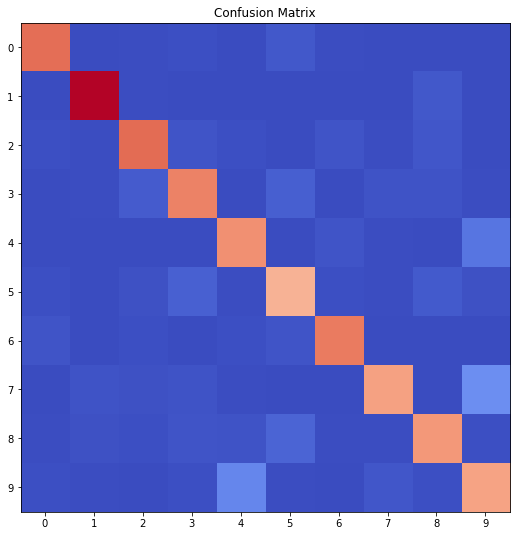

In [53]:
str_labels = [str(label) for label in labels]

_ = plt.figure(figsize = (9,9))
_ = plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
_ = plt.xticks(np.arange(0, 10), str_labels)
_ = plt.yticks(np.arange(0, 10), str_labels)
_ = plt.title("Confusion Matrix")

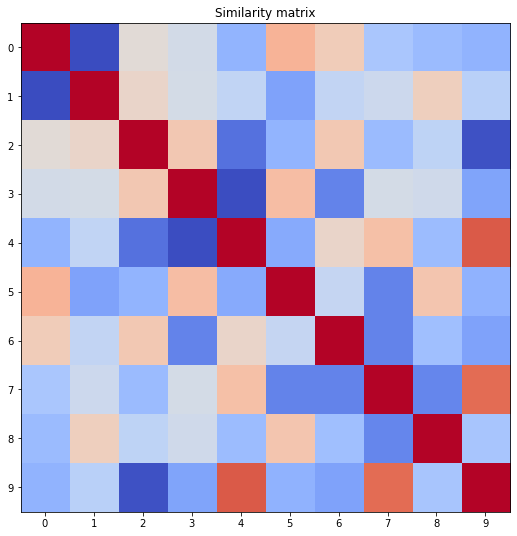

In [54]:
str_labels = [str(label) for label in labels]
label_enc = np.array([target_encoder_model.predict(np.array([target_id]))[0, 0, :] for target_id in range(10)])

_ = plt.figure(figsize = (9,9))
_ = plt.imshow(np.matmul( label_enc, label_enc.T ), interpolation='nearest', cmap='coolwarm')
_ = plt.xticks(np.arange(0, 10), str_labels)
_ = plt.title("Similarity matrix")
_ = plt.yticks(np.arange(0, 10), str_labels)

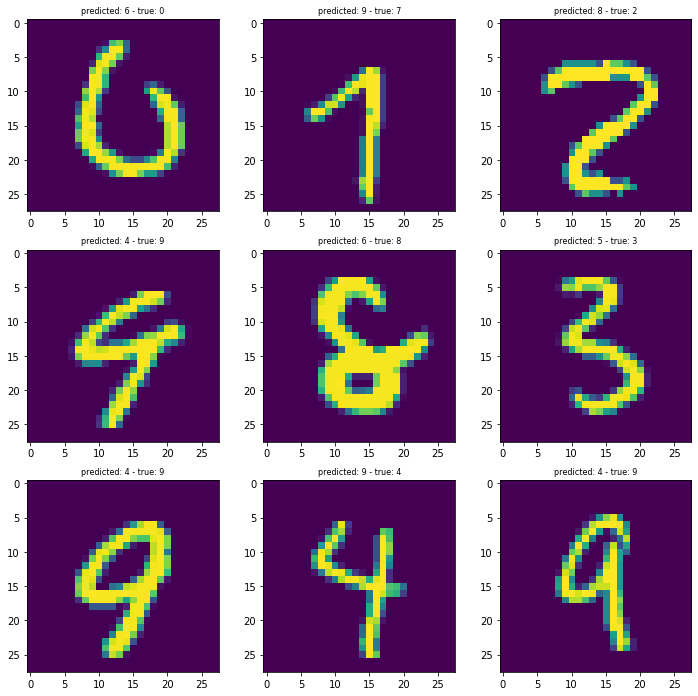

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

wrong_predicted = np.where(y_pred != y_test[:,0])[0]
RANDOM_WRONG_TEST_ID = np.random.choice(wrong_predicted,9)

for i,SAMPLE_ID in enumerate(RANDOM_WRONG_TEST_ID):
    plt.subplot(331 + i)
    
    softmax_emb = np.matmul(input_encoder_model.predict(np.expand_dims(x_test[SAMPLE_ID],(0,1))), target_encoder_model.predict([0,1,2,3,4,5,6,7,8,9])[:,0,:].T)
    prediction = np.argmax(softmax_emb)
    
    plt.imshow(np.reshape(x_test[SAMPLE_ID],(28,28)))
    plt.title(f"predicted: {prediction} - true: {y_test[SAMPLE_ID][0]}", fontsize=8)
plt.show()